In [2]:

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from google.colab import drive
drive.mount('/content/drive')
# set project path to "dallas airbnb" folder
project_path = "/content/drive/MyDrive/dallas airbnb"

# change into that folder
os.chdir(project_path)
print("Now in:", project_path)
print("Files here:", os.listdir(project_path))

# load listings.csv if it exists
if "listings.csv" in os.listdir(project_path):
    listings = pd.read_csv("listings.csv")
    print("✅ Listings loaded:", listings.shape)
    display(listings.head())
else:
    print("⚠️ listings.csv not found in", project_path)


Mounted at /content/drive
Now in: /content/drive/MyDrive/dallas airbnb
Files here: ['listings.csv', 'neighbourhoods.geojson', 'models', 'Dallas_AIRBNB.ipynb', 'Untitled0.ipynb', '11.5 Dallas_AIRBNB.ipynb']
✅ Listings loaded: (5531, 18)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,61878,MODERN LIVING AND FURNISHINGS,300211,Rita,NaN,District 2,32.816900,-96.820180,Entire home/apt,111.0,30,57,2025-04-30,0.32,1,288,2,NaN
1,795703,Amazing location walk to Downtown Dallas,4191322,Michelle,NaN,District 14,32.803270,-96.809760,Entire home/apt,243.0,30,71,2024-07-27,0.47,1,269,1,NaN
2,860248,"Peaceful Home By the Lake: Safe, Cozy, Quiet",4505460,Judy,NaN,District 9,32.855090,-96.706250,Private room,44.0,7,72,2023-09-30,0.67,2,151,0,NaN
3,1154424,"Uptown, Charming Studio 1B,Fast Free WiFi Parking",6063232,Joan,NaN,District 14,32.818684,-96.790154,Entire home/apt,92.0,3,97,2024-10-29,0.66,9,310,3,NaN
4,1277933,The Santa Fe Suite and Maxfield Parrish Suite,6904484,C. F. Sandy,NaN,District 11,32.924490,-96.790620,Private room,55.0,1,30,2019-11-09,0.30,1,166,0,NaN


In [3]:
# drop unnecessary columns
listings_clean = listings.drop(
    columns=["name", "host_id", "host_name", "neighbourhood_group", "last_review", "license"],
    errors="ignore"  # ignore avoids errors if column missing
)

print("Remaining columns:", listings_clean.columns.tolist())
print("Shape:", listings_clean.shape)
listings_clean.head()


Remaining columns: ['id', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm']
Shape: (5531, 12)


,id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,61878,District 2,32.816900,-96.820180,Entire home/apt,111.0,30,57,0.32,1,288,2
1,795703,District 14,32.803270,-96.809760,Entire home/apt,243.0,30,71,0.47,1,269,1
2,860248,District 9,32.855090,-96.706250,Private room,44.0,7,72,0.67,2,151,0
3,1154424,District 14,32.818684,-96.790154,Entire home/apt,92.0,3,97,0.66,9,310,3
4,1277933,District 11,32.924490,-96.790620,Private room,55.0,1,30,0.30,1,166,0


In [6]:
# Make a copy
df = listings_clean.copy()

# ---- Fill categorical columns FIRST (so we can safely filter/map) ----
if "neighbourhood" in df.columns:
    df["neighbourhood"] = df["neighbourhood"].fillna("Unknown")
if "room_type" in df.columns:
    df["room_type"] = df["room_type"].fillna("Unknown")

# ---- Remove Hotel room entries (out of scope) ----
if "room_type" in df.columns:
    before = len(df)
    df = df[df["room_type"] != "Hotel room"]
    after = len(df)
    print(f"Removed {before - after} 'Hotel room' rows")
    print(f"Remaining rows: {after}")

# ---- Convert room_type to numeric codes, then drop original ----
if "room_type" in df.columns:
    room_type_map = {
        "Entire home/apt": 1,
        "Private room": 2,
        "Shared room": 3
    }
    df["room_type_numeric"] = df["room_type"].map(room_type_map).fillna(0).astype(int)
    df = df.drop(columns=["room_type"], errors="ignore")

# ---- Convert likely numeric columns to numeric dtype ----
likely_numeric = [
    "price", "minimum_nights", "availability_365",
    "number_of_reviews", "number_of_reviews_ltm", "reviews_per_month",
    "calculated_host_listings_count", "latitude", "longitude"
]
for col in likely_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# ---- Fill numeric columns (0 or median) ----
fill_zero = [c for c in ["availability_365", "number_of_reviews", "number_of_reviews_ltm", "reviews_per_month"] if c in df.columns]
if fill_zero:
    df[fill_zero] = df[fill_zero].fillna(0)

fill_median = [c for c in ["minimum_nights", "calculated_host_listings_count", "price"] if c in df.columns]
for c in fill_median:
    if c in df.columns:
        df[c] = df[c].fillna(df[c].median())

# ---- Drop rows missing critical geo fields ----
must_have = [c for c in ["latitude", "longitude"] if c in df.columns]
if must_have:
    df = df.dropna(subset=must_have)

# ---- Single DATA QUALITY REPORT ----
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False))

print("\nDuplicate rows (full-row duplicates):", df.duplicated().sum())
if "id" in df.columns:
    print("Duplicate IDs:", df.duplicated(subset=["id"]).sum())

num_cols = ["price", "minimum_nights", "availability_365", "reviews_per_month"]
for c in num_cols:
    if c in df.columns:
        print(f"\n{c} -> min: {df[c].min()}, max: {df[c].max()}, mean: {df[c].mean():.2f}, median: {df[c].median():.2f}")



Removed 47 'Hotel room' rows
Remaining rows: 5484

Missing values per column:
id                                0
neighbourhood                     0
latitude                          0
longitude                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
room_type_numeric                 0
dtype: int64

Duplicate rows (full-row duplicates): 0
Duplicate IDs: 0

price -> min: 9.0, max: 50000.0, mean: 305.73, median: 124.00

minimum_nights -> min: 1, max: 365, mean: 8.18, median: 2.00

availability_365 -> min: 0, max: 365, mean: 249.54, median: 298.00

reviews_per_month -> min: 0.0, max: 25.27, mean: 1.74, median: 1.03


In [7]:
# Remove leading "'" from latitude values and convert to float
df["latitude"] = df["latitude"].astype(str).str.lstrip("'").astype(float)

In [10]:
# --- Filters ---
before = len(df)

df = df[(df["price"] > 0) & (df["price"] <= 1000)]
df = df[(df["minimum_nights"] >= 1) & (df["minimum_nights"] <= 365)]
df = df[df["availability_365"].between(0, 365)]
df = df[df["reviews_per_month"] >= 0]

after = len(df)
print(f"Rows before filtering: {before}")
print(f"Rows after filtering:  {after}")
print(f"Dropped rows: {before - after}")

# --- Create binary column: 1 if Entire home/apt, else 0 ---
if "is_entire_home" not in df.columns:
    if "room_type_numeric" in df.columns:
        # 1 = Entire home/apt (your mapping), 2 = Private room, 3 = Shared room
        df["is_entire_home"] = (df["room_type_numeric"] == 1).astype(int)
    elif "room_type" in df.columns:
        df["is_entire_home"] = (df["room_type"] == "Entire home/apt").astype(int)
    else:
        raise KeyError("Neither 'room_type_numeric' nor 'room_type' is present to create 'is_entire_home'.")

# Optional: quick check
# print(df["is_entire_home"].value_counts())


Rows before filtering: 5392
Rows after filtering:  5392
Dropped rows: 0


In [11]:
from sklearn.preprocessing import LabelEncoder

# initialize encoder
encoder = LabelEncoder()

# fit and transform neighbourhood column
df["neighbourhood_encoded"] = encoder.fit_transform(df["neighbourhood"])

# check results
print(df[["neighbourhood", "neighbourhood_encoded"]].head(10))

  neighbourhood  neighbourhood_encoded
0    District 2                      6
1   District 14                      5
2    District 9                     13
3   District 14                      5
4   District 11                      2
5   District 14                      5
6   District 14                      5
7   District 14                      5
8    District 2                      6
9   District 14                      5


In [12]:
print(df.head())

        id neighbourhood   latitude  longitude  price  minimum_nights  \
0    61878    District 2  32.816900 -96.820180  111.0              30   
1   795703   District 14  32.803270 -96.809760  243.0              30   
2   860248    District 9  32.855090 -96.706250   44.0               7   
3  1154424   District 14  32.818684 -96.790154   92.0               3   
4  1277933   District 11  32.924490 -96.790620   55.0               1   

   number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                 57               0.32                               1   
1                 71               0.47                               1   
2                 72               0.67                               2   
3                 97               0.66                               9   
4                 30               0.30                               1   

   availability_365  number_of_reviews_ltm  room_type_numeric  is_entire_home  \
0               288          

In [19]:
# Create new feature: price * room_type_numeric
df["price_weighted_roomtype"] = df["price"] * df["room_type_numeric"]

print(df[["price", "room_type_numeric", "price_weighted_roomtype"]].head())

# --- Create new feature: potential annual revenue ---
df["potential_revenue"] = df["price"] * (365 - df["availability_365"])


   price  room_type_numeric  price_weighted_roomtype
0  111.0                  1                    111.0
1  243.0                  1                    243.0
2   44.0                  2                     88.0
3   92.0                  1                     92.0
4   55.0                  2                    110.0


In [20]:
# --- BASIC DATA OVERVIEW ---
print("DataFrame shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())

print("\nData types:")
print(df.dtypes)

# Quick sample
df.head()

# --- NUMERIC SUMMARY STATISTICS ---
df.describe().T

DataFrame shape: (5392, 16)

Column names:
['id', 'neighbourhood', 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'room_type_numeric', 'is_entire_home', 'neighbourhood_encoded', 'price_weighted_roomtype', 'potential_revenue']

Data types:
id                                  int64
neighbourhood                      object
latitude                          float64
longitude                         float64
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
room_type_numeric                   int64
is_entire_home                      int64
neighbourhood_encoded               int64
price_weighted_roomtype           float64
poten

,count,mean,std,min,25%,50%,75%,max
id,5392.0,8.465504e+17,5.296776e+17,61878.000000,5.550558e+17,1.035507e+18,1.289295e+18,1.443586e+18
latitude,5392.0,3.280769e+01,6.393380e-02,32.633790,3.277688e+01,3.280021e+01,3.282224e+01,3.301515e+01
longitude,5392.0,-9.679496e+01,4.908359e-02,-96.992697,-9.682470e+01,-9.679499e+01,-9.677098e+01,-9.648124e+01
price,5392.0,1.610484e+02,1.316368e+02,9.000000,8.600000e+01,1.240000e+02,1.852500e+02,1.000000e+03
minimum_nights,5392.0,8.186387e+00,1.894314e+01,1.000000,1.000000e+00,2.000000e+00,4.000000e+00,3.650000e+02
number_of_reviews,5392.0,4.316710e+01,8.389503e+01,0.000000,2.000000e+00,1.400000e+01,4.600000e+01,1.339000e+03
reviews_per_month,5392.0,1.760645e+00,2.004111e+00,0.000000,2.300000e-01,1.070000e+00,2.642500e+00,2.527000e+01
calculated_host_listings_count,5392.0,1.250797e+01,2.147710e+01,1.000000,1.000000e+00,4.000000e+00,1.400000e+01,1.190000e+02
availability_365,5392.0,2.490389e+02,1.164545e+02,0.000000,1.670000e+02,2.960000e+02,3.500000e+02,3.650000e+02
number_of_reviews_ltm,5392.0,1.400037e+01,1.996651e+01,0.000000,1.000000e+00,6.000000e+00,2.000000e+01,3.860000e+02


In [21]:
# --- MISSING VALUE SUMMARY ---
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Missing values per column:\n", missing)

# --- DUPLICATE CHECK ---
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

if "id" in df.columns:
    print("Duplicate IDs:", df.duplicated(subset=["id"]).sum())

Missing values per column:
 Series([], dtype: int64)
Number of duplicate rows: 0
Duplicate IDs: 0


/tmp/ipython-input-3268807036.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df["potential_revenue"], palette="Blues")
/tmp/ipython-input-3268807036.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df["potential_revenue"], palette="Blues")


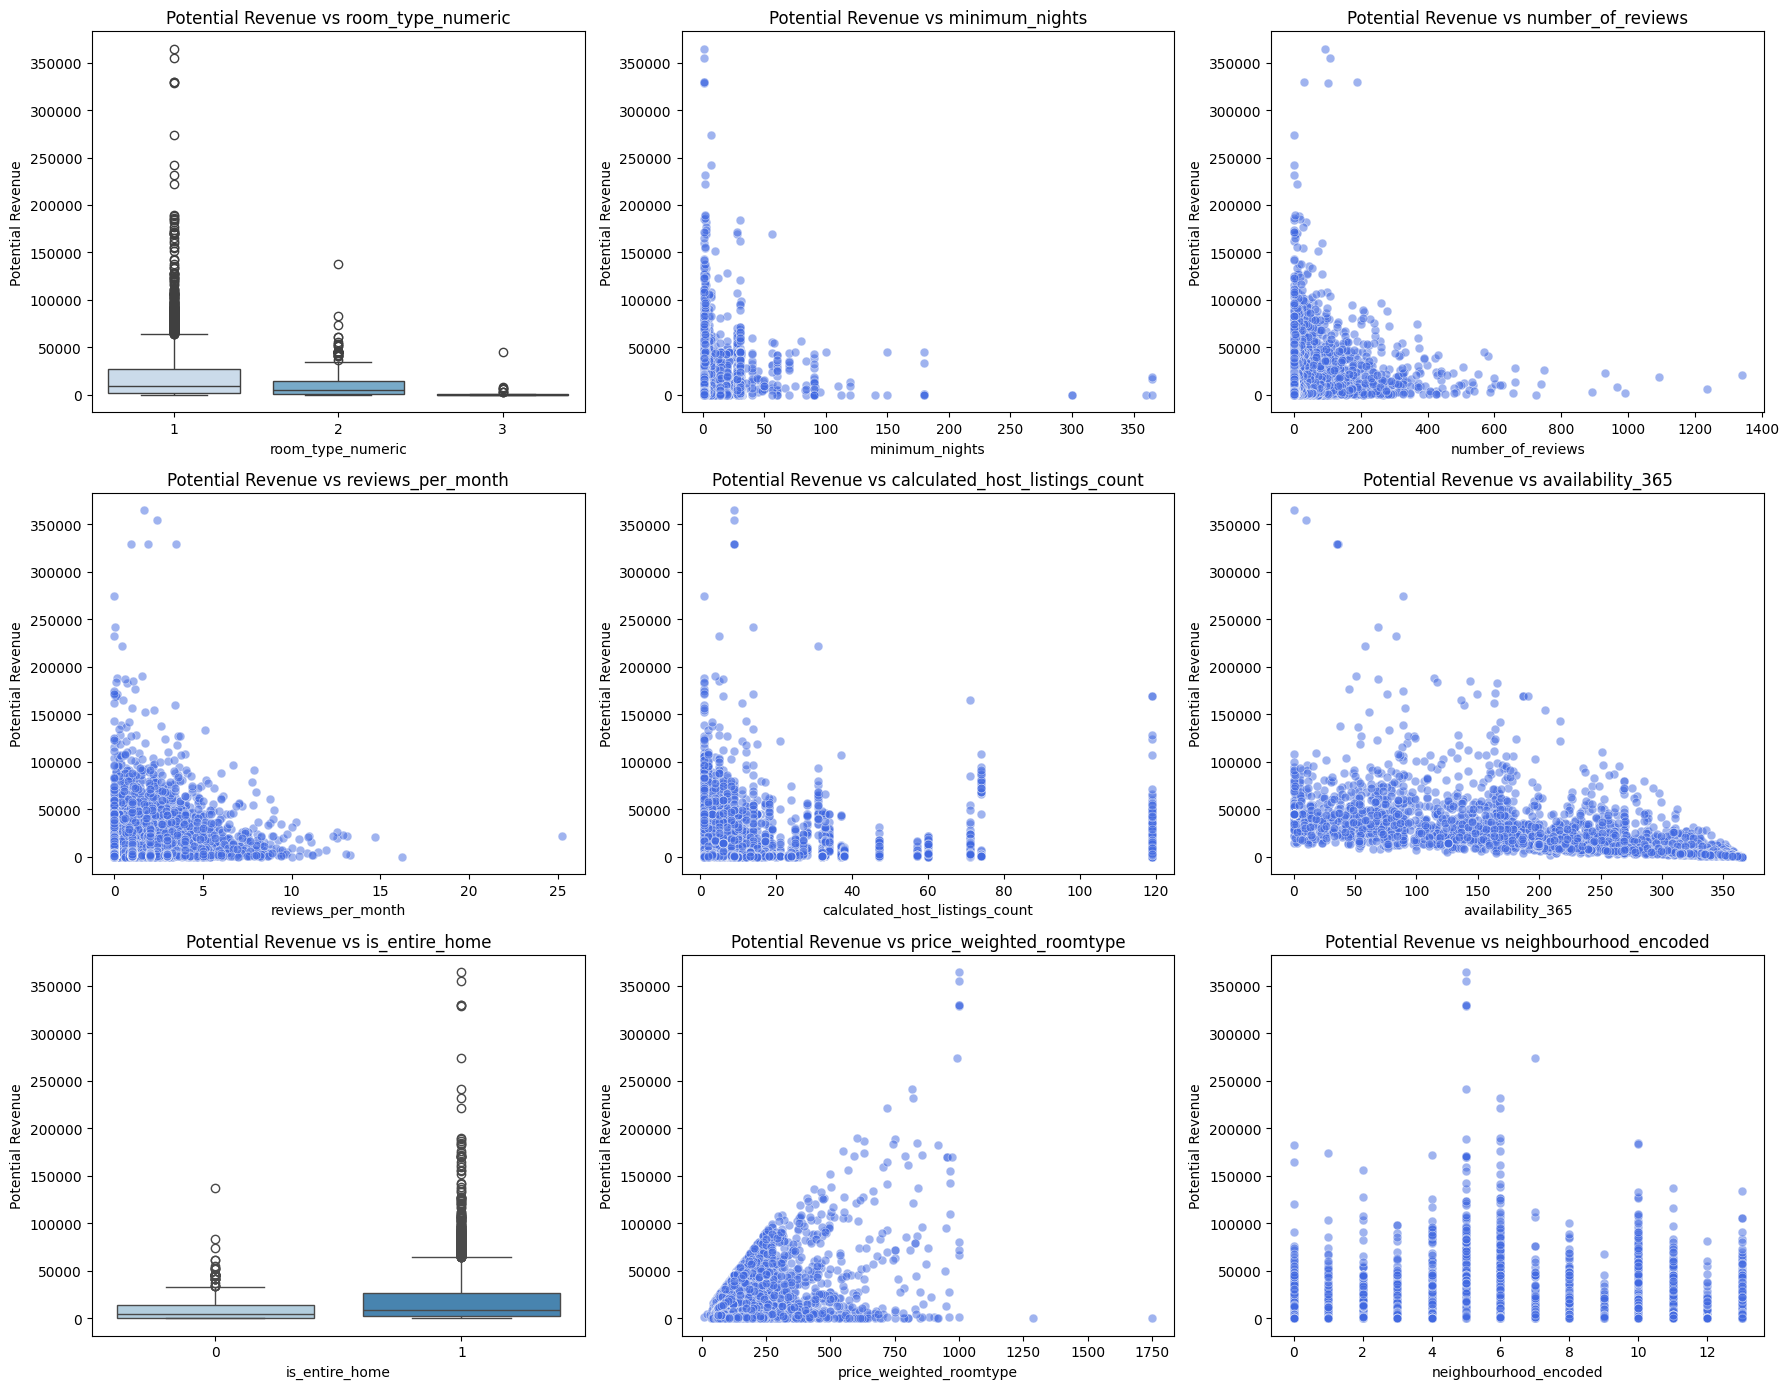

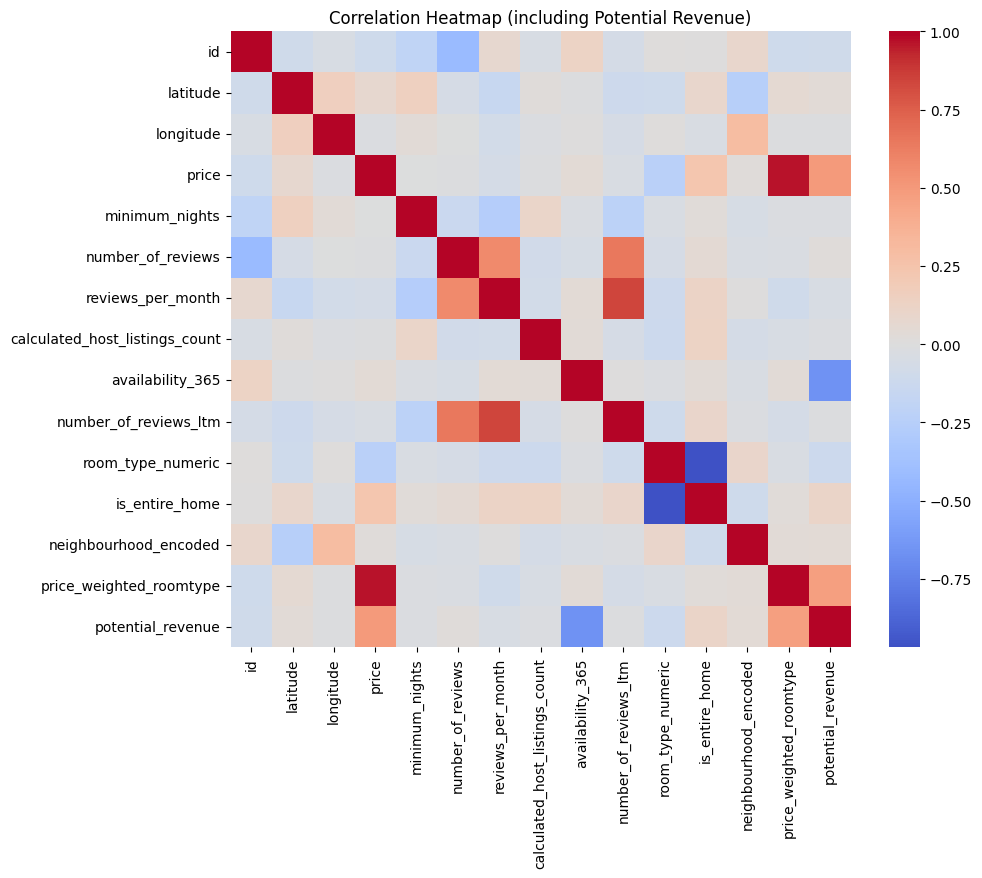

Correlation of each feature with potential_revenue:

potential_revenue                 1.000000
price                             0.497201
price_weighted_roomtype           0.475244
is_entire_home                    0.112577
neighbourhood_encoded             0.040238
latitude                          0.035339
number_of_reviews                 0.018186
number_of_reviews_ltm            -0.008744
longitude                        -0.014737
calculated_host_listings_count   -0.018655
minimum_nights                   -0.022369
reviews_per_month                -0.039364
id                               -0.093122
room_type_numeric                -0.116919
availability_365                 -0.664470
Name: potential_revenue, dtype: float64


In [22]:

num_features = [
    "room_type_numeric",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
    "is_entire_home",
    "price_weighted_roomtype",
    "neighbourhood_encoded"
]

plt.figure(figsize=(18, 14))
for i, col in enumerate(num_features, 1):
    plt.subplot(3, 3, i)

    # Boxplot for categorical-like vars, scatter for continuous
    if df[col].nunique() < 10:
        sns.boxplot(x=df[col], y=df["potential_revenue"], palette="Blues")
    else:
        sns.scatterplot(x=df[col], y=df["potential_revenue"], alpha=0.5, color="royalblue", s=40)

    plt.title(f"Potential Revenue vs {col}")
    plt.xlabel(col)
    plt.ylabel("Potential Revenue")

plt.tight_layout()
plt.show()

# --- CORRELATION HEATMAP ---
plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", annot=False, center=0)
plt.title("Correlation Heatmap (including Potential Revenue)")
plt.show()

# Focused correlation values with potential_revenue
corr_target = corr["potential_revenue"].sort_values(ascending=False)
print("Correlation of each feature with potential_revenue:\n")
print(corr_target)

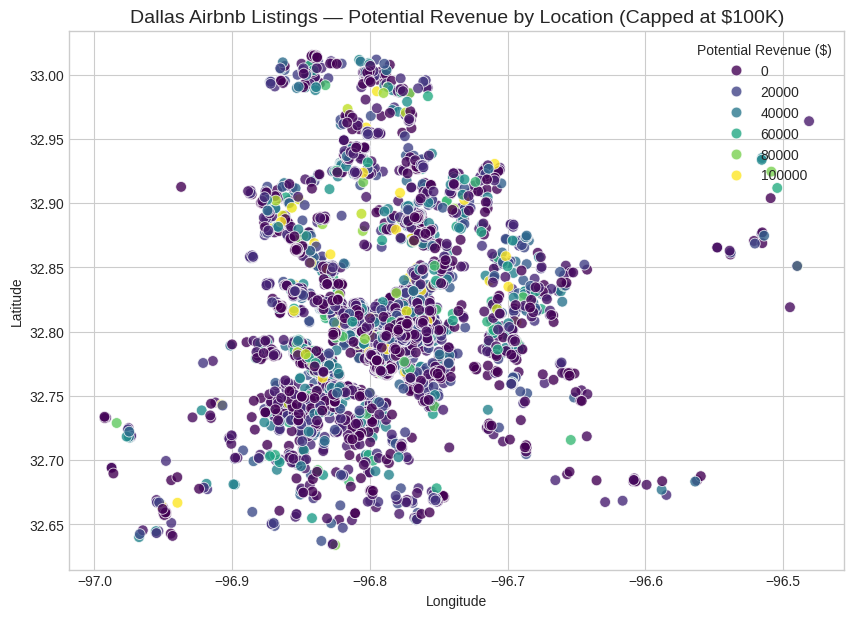

/tmp/ipython-input-3410521463.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_neigh.values, y=top_neigh.index, palette="coolwarm")


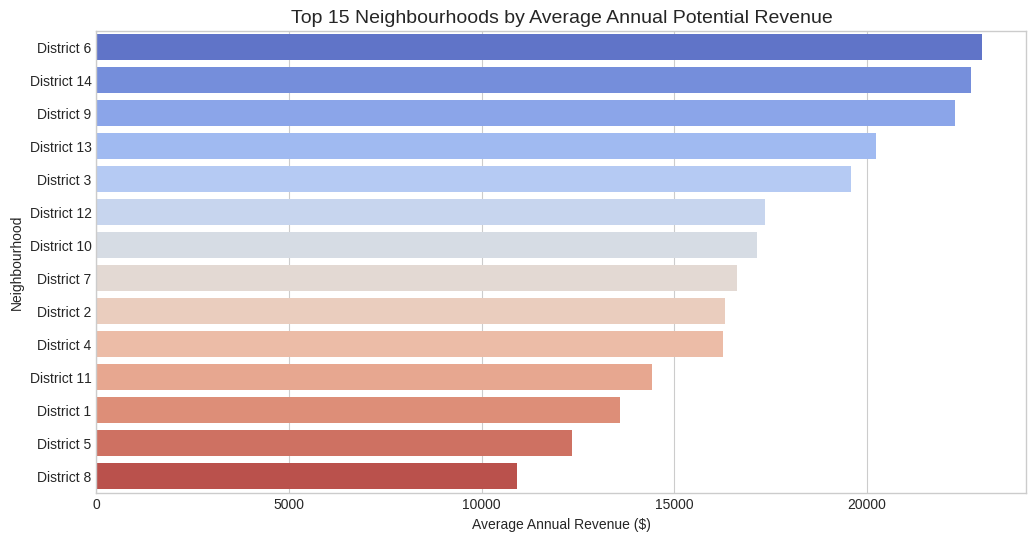

/tmp/ipython-input-3410521463.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


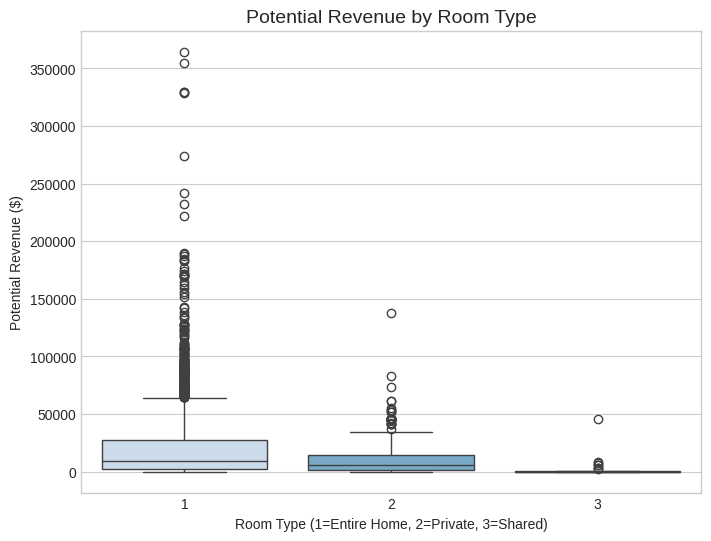

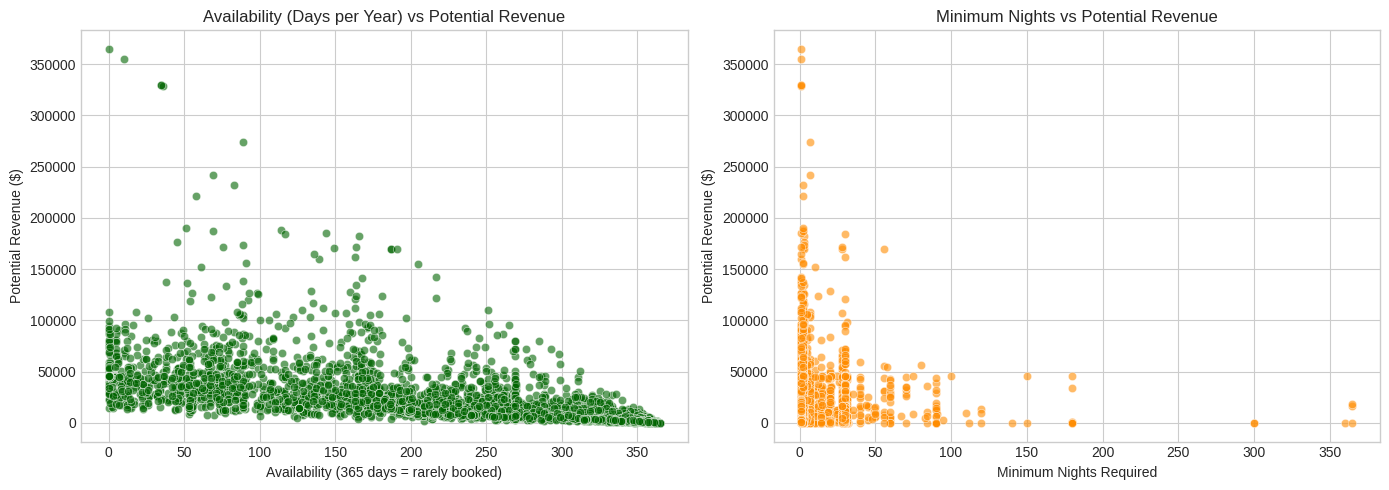

In [25]:


plt.style.use("seaborn-v0_8-whitegrid")

# --- 1. GEO SCATTERPLOT (capped at 100K) ---
df["potential_revenue_capped"] = np.where(df["potential_revenue"] > 100000, 100000, df["potential_revenue"])

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="longitude",
    y="latitude",
    hue="potential_revenue_capped",
    data=df,
    palette="viridis",
    alpha=0.8,
    s=60
)
plt.title("Dallas Airbnb Listings — Potential Revenue by Location (Capped at $100K)", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Potential Revenue ($)", loc="upper right")
plt.show()

# --- 2. TOP NEIGHBOURHOODS BY AVERAGE REVENUE ---
if "neighbourhood" in df.columns:
    plt.figure(figsize=(12, 6))
    top_neigh = (
        df.groupby("neighbourhood")["potential_revenue"]
        .mean()
        .sort_values(ascending=False)
        .head(15)
    )
    sns.barplot(x=top_neigh.values, y=top_neigh.index, palette="coolwarm")
    plt.title("Top 15 Neighbourhoods by Average Annual Potential Revenue", fontsize=14)
    plt.xlabel("Average Annual Revenue ($)")
    plt.ylabel("Neighbourhood")
    plt.show()

# --- 3. ROOM TYPE VS POTENTIAL REVENUE ---
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="room_type_numeric",
    y="potential_revenue",
    data=df,
    palette="Blues"
)
plt.title("Potential Revenue by Room Type", fontsize=14)
plt.xlabel("Room Type (1=Entire Home, 2=Private, 3=Shared)")
plt.ylabel("Potential Revenue ($)")
plt.show()

# --- 4. CONTINUOUS RELATIONSHIPS ---
plt.figure(figsize=(14, 5))

# Availability vs Revenue
plt.subplot(1, 2, 1)
sns.scatterplot(
    x="availability_365",
    y="potential_revenue",
    data=df,
    alpha=0.6,
    color="darkgreen"
)
plt.title("Availability (Days per Year) vs Potential Revenue")
plt.xlabel("Availability (365 days = rarely booked)")
plt.ylabel("Potential Revenue ($)")

# Minimum nights vs Revenue
plt.subplot(1, 2, 2)
sns.scatterplot(
    x="minimum_nights",
    y="potential_revenue",
    data=df,
    alpha=0.6,
    color="darkorange"
)
plt.title("Minimum Nights vs Potential Revenue")
plt.xlabel("Minimum Nights Required")
plt.ylabel("Potential Revenue ($)")

plt.tight_layout()
plt.show()


 EDA Findings Summary

- **Revenue Drivers:** The strongest revenue drivers are price and occupancy (availability_365). Listings with lower availability — meaning they are frequently booked — yield the highest potential revenue.
- **Room Type Impact:** Entire homes generate significantly higher revenue than private or shared rooms, indicating that full-space rentals are the most profitable investment type.
- **Minimum Nights Policy:** Flexible minimum stay policies (7 nights) correlate with higher potential revenue due to increased booking frequency.
- **Geographic Variation:** Revenue clusters appear in central Dallas areas (likely Uptown and Downtown), suggesting strong demand in these neighborhoods.


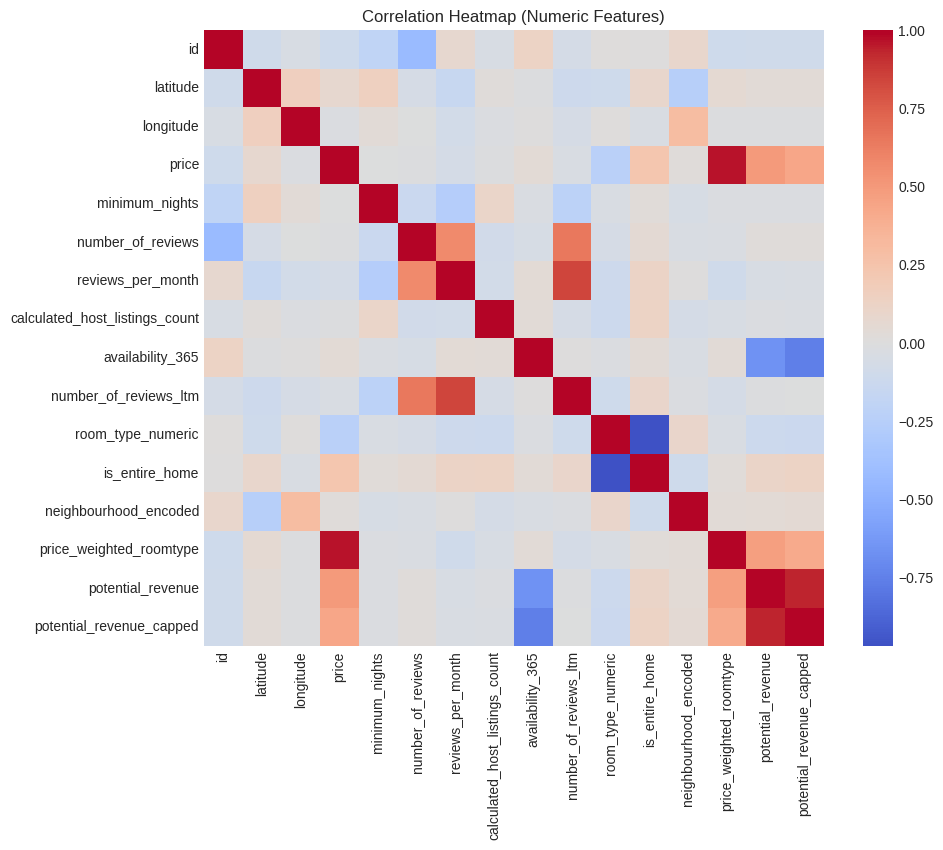

In [26]:
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

EDA Findings and Insights Summary

There are more than 5,000 clean Dallas Airbnb listings in the data.
Imputed missing values, fixed data types, and excluded hotel room entries as they are not part of our research.
Encoded text columns and cleaned and standardized numeric columns.

We created several new features for making the data more interpretable:
- room_type_numeric: converted text room types to numbers.
- is_entire_home: a flag for whether the property is an entire home or not.
- price_weighted_roomtype: a grouping of price and room type information.
- potential_revenue: potential yearly revenue from Airbnb stays. This is our response variable.

The main points are:
- Price and availability have the most impact on revenue.
Lower availability (i.e., the property is booked more frequently) produces higher potential revenue.
- Entire houses make more than shared rooms or rooms.
- Properties with short stay minimum nights (below one week) get more annual revenue.
- The highest earning places are in central Dallas, such as Uptown and Downtown.

Making text more visually readable, revenue amounts above $100,000 were cut off.
This focuses on realistic listings and avoids outliers.

In short, entire houses in central areas with high booking rates and low stay periods have the greatest investment value on the Dallas Airbnb market.
These findings will guide the next step where we will build a model to project based on these characteristics.